The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


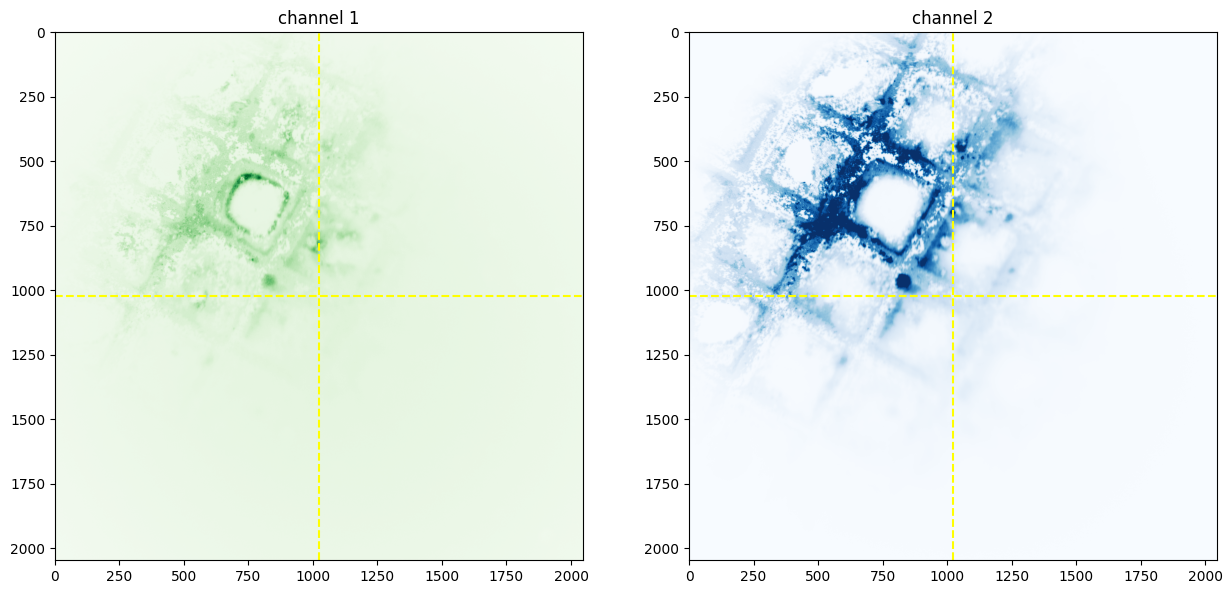

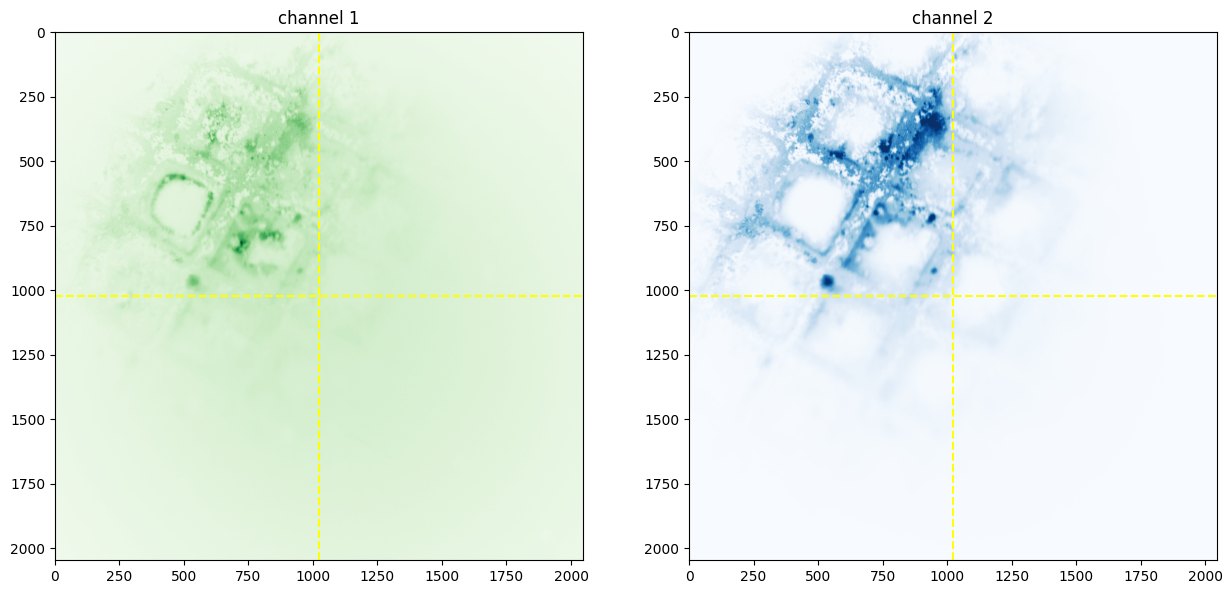

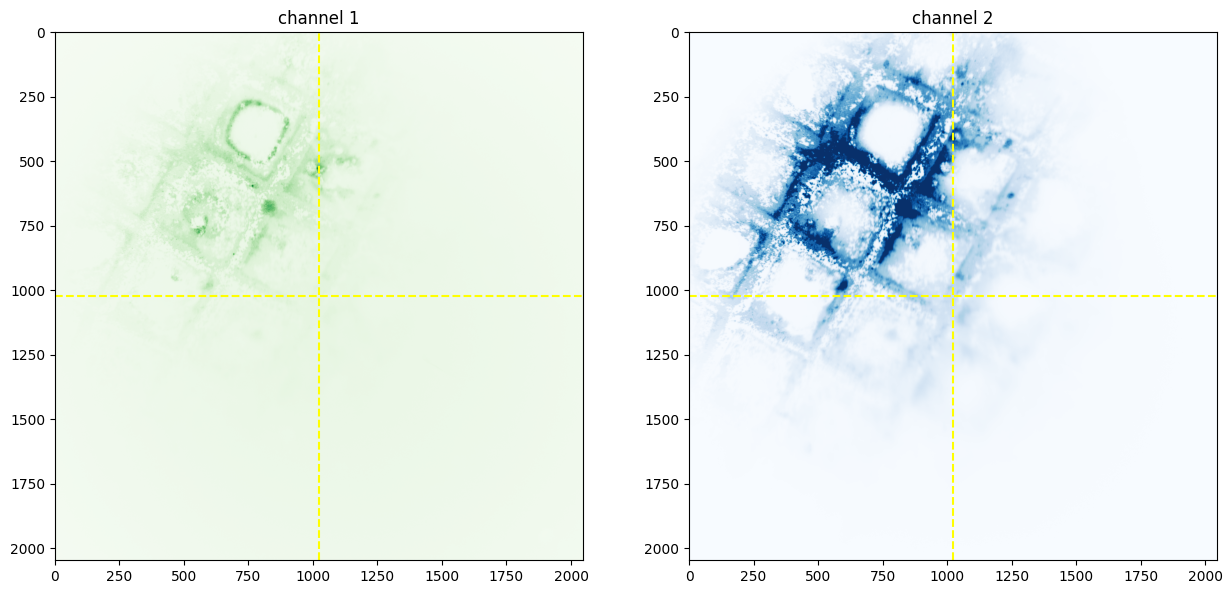

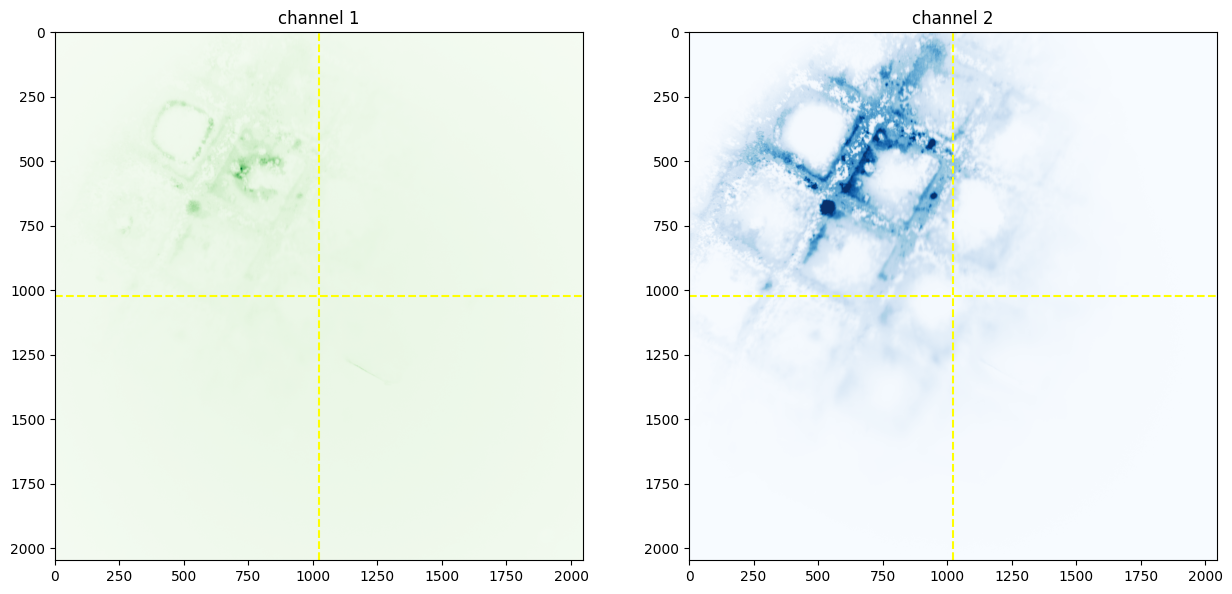

In [14]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from openlm.structures import LightImage

from pprint import pprint


import glob
import os

# path = r"D:\David\piescope_dev\tile"
# path = r"C:\Users\Admin\Github\openclem\openlm\log\workflow_2023-05-09-04-53-32-570840PM"
path = r"C:\Users\Admin\Github\openclem\openlm\log\workflow_2023-05-09-05-11-06-661800PM"
filenames = sorted(glob.glob(os.path.join(path, "*.tif")))

for fname in filenames:
    img = LightImage.load(fname)
    
    # print(fname)
    # print(img.data.shape)
    # print(img.metadata.channels)
    # print(img.metadata.stage)
    # print(img.metadata.image.workflow)

    # subplots
    fig, axs = plt.subplots(1, img.data.shape[2], figsize=(15, 10))

    for i, channels in enumerate(img.metadata.channels):
        cmap = "Greens" if i == 0 else "Blues"
        axs[i].imshow(img.data[:, :, i], cmap=cmap)
        axs[i].set_title(f"channel {channels}")

        #centre crosshair, dashed line
        axs[i].axvline(img.data.shape[0]//2, linestyle="--", color="yellow")
        axs[i].axhline(img.data.shape[1]//2, linestyle="--", color="yellow")

    plt.show()

In [ ]:
from pprint import pprint 
pprint(img.metadata.channels)
pprint(img.metadata.time)
pprint(img.metadata.lasers)
pprint(img.metadata.detector)
pprint(img.metadata.sync)
pprint(img.metadata.objective)
pprint(img.metadata.stage)


WorkflowSettings(n_rows=2, n_cols=2, dx=0.0001, dy=0.0001, n_slices=1, dz=5e-06)
0 0 0 0 C:\Users\Admin\Github\openclem\openlm\log\workflow_2023-05-09-05-11-06-661800PM\2023-05-09-05-11-10-548001PM.tif
0 1 0 1 C:\Users\Admin\Github\openclem\openlm\log\workflow_2023-05-09-05-11-06-661800PM\2023-05-09-05-11-18-666672PM.tif
1 0 0 2 C:\Users\Admin\Github\openclem\openlm\log\workflow_2023-05-09-05-11-06-661800PM\2023-05-09-05-11-27-044273PM.tif
1 1 0 3 C:\Users\Admin\Github\openclem\openlm\log\workflow_2023-05-09-05-11-06-661800PM\2023-05-09-05-11-35-137946PM.tif


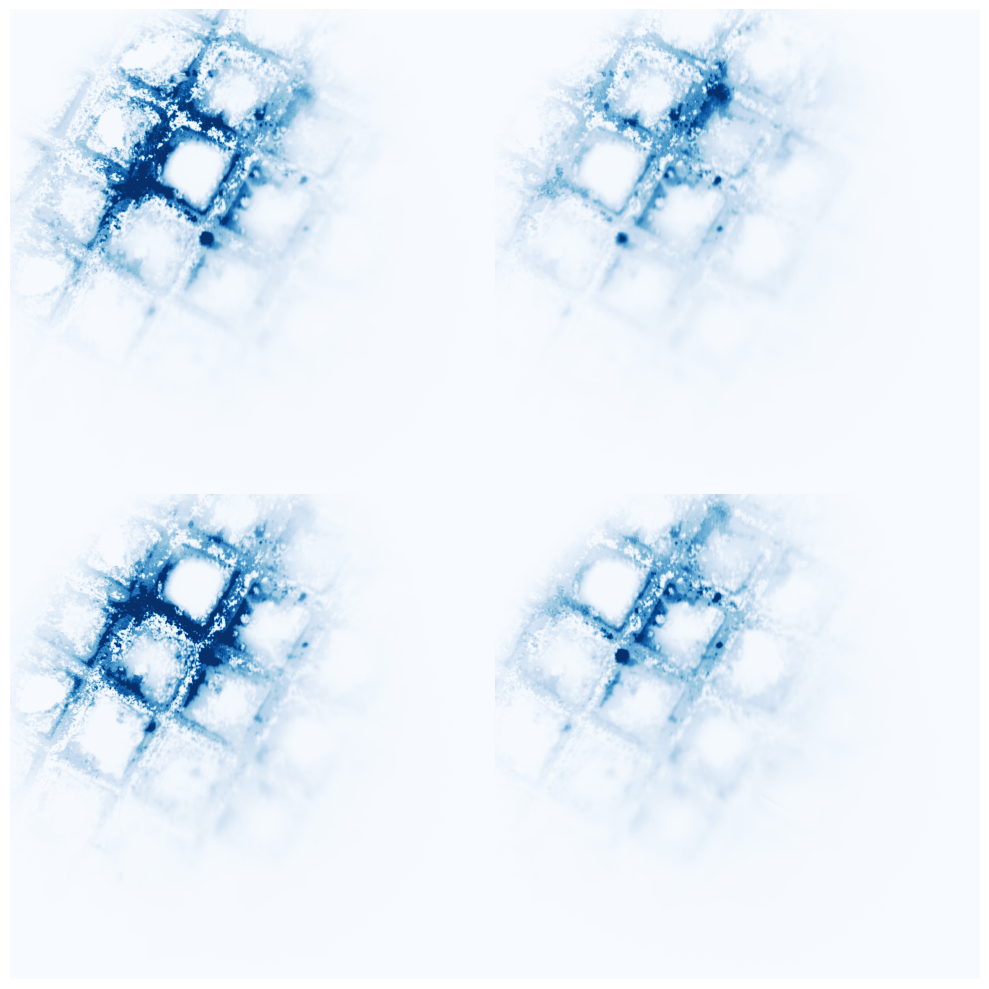

In [22]:

from openlm.structures import WorkflowSettings

wf = WorkflowSettings.__from_dict__(LightImage.load(filenames[0]).metadata.image.workflow)

pprint(wf)

fig, ax = plt.subplots(wf.n_rows, wf.n_cols, figsize=(10, 10))


idx = 0
for row in range(wf.n_rows):
    for col in range(wf.n_cols):
        for vol in range(wf.n_slices):
            print(row, col, vol, idx, filenames[idx])
            img = LightImage.load(filenames[idx])
            ax[row, col].imshow(img.data[:, :, 1], cmap="Blues")
            # ax[row, col].set_title(f"row {row}, col {col}, vol {vol}")
            idx += 1

            # tight subplot, no axes
            ax[row, col].axis("off")

plt.tight_layout()
# remove spacing
plt.subplots_adjust(wspace=0, hspace=0)


plt.show()

## Microscope State

In [ ]:
%load_ext autoreload
%autoreload 2

import logging

from openlm import utils
from openlm import config as cfg
import os

from fibsem import utils as fibsem_utils


import os
from openlm import utils
from openlm import config
from openlm.structures import ImageMode, SynchroniserMessage, ImageSettings, DetectorSettings
import time
import logging
import numpy as np
from PIL import Image

from dataclasses import dataclass
from openlm.structures import (LaserSettings, ImageMode, TriggerEdge, TriggerSource, 
    DetectorSettings, ObjectiveSettings, LightImage, LightImageMetadata)

from openlm.workflow import test_acq


In [ ]:
CFG_PATH = os.path.join(cfg.BASE_PATH, "config", "piedisc.yaml")
microscope, settings = utils.setup_session(config_path=CFG_PATH)
microscope.fibsem_microscope, microscope.fibsem_settings = fibsem_utils.setup_session()

In [ ]:
# SINGLE IMAGE



# what is a workflow
# a list of workflow steps

# what is a workflow step
# a function to run




## Workflow Generation

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np

from pprint import pprint

In [ ]:
def _gen_tiles(n_rows: int = 1, n_cols: int = 1, dx:float = 0, dy: float = 0.0)-> list:
    # relative position of each tile
    return [{"type": "move_stage", "dx":j*dx, "dy":i*dy} for i in range(n_rows) for j in range(n_cols)]


def _gen_vol():
    return


In [ ]:
tile_list = _gen_tiles(n_rows=3, n_cols=3, dx=1, dy=1)
pprint(tile_list)

In [ ]:
from dataclasses import dataclass

from openlm.microscope import LightMicroscope
from abc import ABC, abstractmethod

@dataclass
class OpenLMSWorkflowStep(ABC):
    type: str
    name: str
    params: dict

    @abstractmethod
    def run(self, microscope: LightMicroscope, return_func=None, *args, **kwargs):
        pass

class OpenLMSWorkflowStepMoveStage(OpenLMSWorkflowStep):
    def __init__(self, name: str, params: dict):
        super().__init__(type="move_stage", name=name, params=params)

    def run(self,microscope: LightMicroscope, return_func=None ):
        worker = microscope.move_stage(dx=self.params["dx"], dy=self.params["dy"])
        worker.returned.connect(return_func)  # type: ignore
        worker.start()

class OpenLMSWorkflowStepAcquireImage(OpenLMSWorkflowStep):
    def __init__(self, name: str, params: dict):
        super().__init__(type="acquire_image", name=name, params=params)

    def run(self, microscope: LightMicroscope, return_func=None ):
        self.params["stop_event"].clear()
        microscope.setup_acquisition()

        # TODO: disable other microscope interactions
        worker = microscope.consume_image_queue(save=True, parent_ui=self.params["parent_ui"])
        worker.returned.connect(return_func)  # type: ignore
        worker.start()

        time.sleep(1)

        # acquire image
        self.params["parent_ui"].image_queue, self.params["parent_ui"].stop_event = self.microscope.acquire_image(
            image_settings=self.params["settings"],
            sync_message=self.params["sync"],
            stop_event=self.params["parent_ui"].stop_event,
        )

class OpenLMSWorkflowStepMoveObjective(OpenLMSWorkflowStep):
    def __init__(self, name: str, params: dict):
        super().__init__(type="move_objective", name=name, params=params)

    def run(self, microscope: LightMicroscope, return_func=None, ):
        logging.info(f"Objective Move: {self.params['dz']}")
        worker = microscope.move_objective_stage(dz=self.params["dz"])
        worker.returned.connect(return_func)  # type: ignore
        worker.start()







### Worfklow

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import itertools
from pprint import pprint

from openlm.workflow import _gen_tiling_workflow, _gen_volume_workflow, _gen_workflow
from openlm.structures import ImageSettings, SynchroniserMessage

In [ ]:


image_settings = ImageSettings()
sync_message = SynchroniserMessage(exposures=None, pins=None)

tile_coords = _gen_tiling_workflow(n_rows=2, n_cols=2, dx=100e-6, dy=100e-6)
# This gives us the relative x, y coordinates for each imaging position

volume_coords = _gen_volume_workflow(n_slices=3, step_size=5e-6)
# This gives us the relative z coordinates for each imaging position

workflow = _gen_workflow(tile_coords, volume_coords, 
                         image_settings=image_settings, 
                         sync_message=sync_message,
                         ) 


In [ ]:
# print(f"Workflow Length: {len(workflow)}")
# pprint(workflow)

# counter how many dicts have type = "image"
from collections import Counter
counter = Counter([step["type"] for step in workflow])

pprint(counter)

# import pandas as pd
# df = pd.DataFrame(workflow)
# pd.set_option("display.max_rows", None)
# display(df)


In [ ]:


def test_gen_workflow(n_rows, n_cols, n_slices):
    initial_position = [0, 0, 0]

    tile_coords = _gen_tiling_workflow(n_rows=n_rows, n_cols=n_cols, dx=1, dy=1)
    volume_coords = _gen_volume_workflow(n_slices=n_slices, step_size=1)
    workflow = _gen_workflow(tile_coords, volume_coords, initial_position=initial_position)

    counter = Counter([step["type"] for step in workflow])

    assert counter["move_stage"] == n_rows * n_cols, f"Expected {n_rows * n_cols} move_stage steps, got {counter['move_stage']}"
    assert counter["move_objective"] == n_slices * n_cols * n_rows + 1, f"Expected {n_slices * n_cols * n_rows + 1} move_objective steps, got {counter['move_objective']}"
    assert counter["acquire_image"] == n_rows * n_cols * n_slices, f"Expected {n_rows * n_cols * n_slices} acquire_image steps, got {counter['acquire_image']}"


# test_gen_workflow(n_rows=2, n_cols=2, n_slices=1)
# test_gen_workflow(n_rows=2, n_cols=2, n_slices=2)
test_gen_workflow(n_rows=2, n_cols=2, n_slices=3)